In [1]:
from scipy.io import loadmat

# 读取 MAT 文件
data = loadmat('scm.trajectory.data_2025-03-04_20-19.mat')

# 提取数据
x1 = data['filtered_data_x1']
x2 = data['filtered_data_x2']
y1 = data['filtered_data_y1']
y2 = data['filtered_data_y2']
x = data['x']
y = data['y']

print('x1:',x1.shape,'x2:',x2.shape,'y1:',y1.shape,'y2:',y2.shape,'x:',x.shape,'y:',y.shape)


x1: (308, 2) x2: (337, 2) y1: (907, 2) y2: (525, 2) x: (1, 5) y: (1, 5)


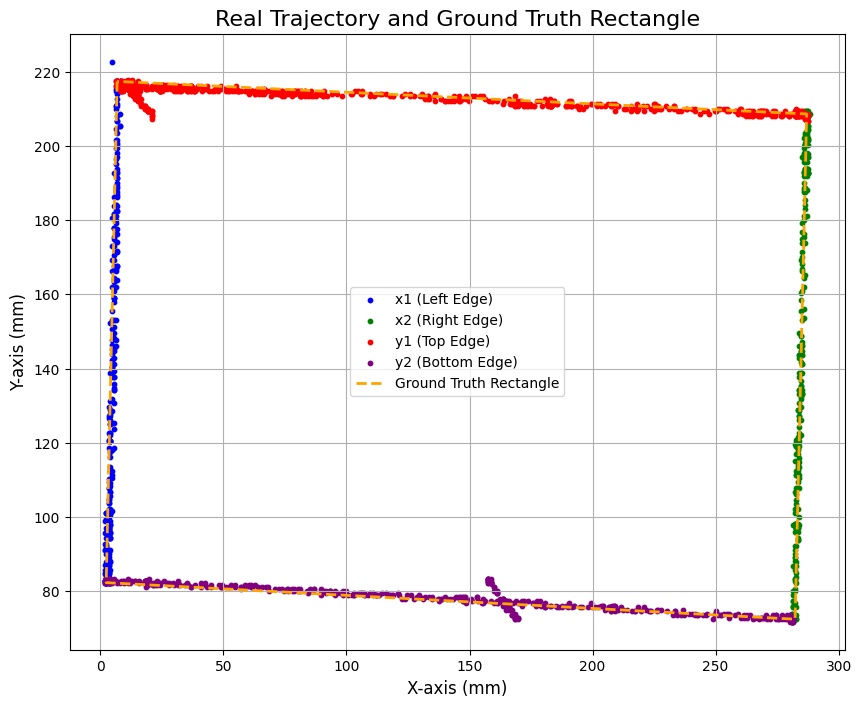

In [2]:
import matplotlib.pyplot as plt
import numpy as np

# 假设从 MATLAB 读取的数据如下（替换为你的实际数据）
# 轨迹点数据
ax_points = x1[:, 0]  # x1 的 X 坐标
ay_points = x1[:, 1]  # x1 的 Y 坐标

bx_points = x2[:, 0]  # x2 的 X 坐标
by_points = x2[:, 1]  # x2 的 Y 坐标

cx_points = y1[:, 0]  # y1 的 X 坐标
cy_points = y1[:, 1]  # y1 的 Y 坐标

dx_points = y2[:, 0]  # y2 的 X 坐标
dy_points = y2[:, 1]  # y2 的 Y 坐标

# 矩形顶点数据
rectangle_x = x[0, :]  # 矩形的 X 坐标
rectangle_y = y[0, :]  # 矩形的 Y 坐标

# 绘制图形
plt.figure(figsize=(10, 8))

# 绘制轨迹点
plt.scatter(ax_points, ay_points, color='blue', s=10, label='x1 (Left Edge)')
plt.scatter(bx_points, by_points, color='green', s=10, label='x2 (Right Edge)')
plt.scatter(cx_points, cy_points, color='red', s=10, label='y1 (Top Edge)')
plt.scatter(dx_points, dy_points, color='purple', s=10, label='y2 (Bottom Edge)')

# 绘制矩形
plt.plot(rectangle_x, rectangle_y, color='orange', linestyle='--', linewidth=2, label='Ground Truth Rectangle')

# 图形美化
plt.title('Real Trajectory and Ground Truth Rectangle', fontsize=16)
plt.xlabel('X-axis (mm)', fontsize=12)
plt.ylabel('Y-axis (mm)', fontsize=12)
plt.legend(fontsize=10)
plt.grid(True)

# 显示图形
plt.show()

RMS of X-direction error: 0.4401 mm
RMS of Y-direction error: 1.4364 mm


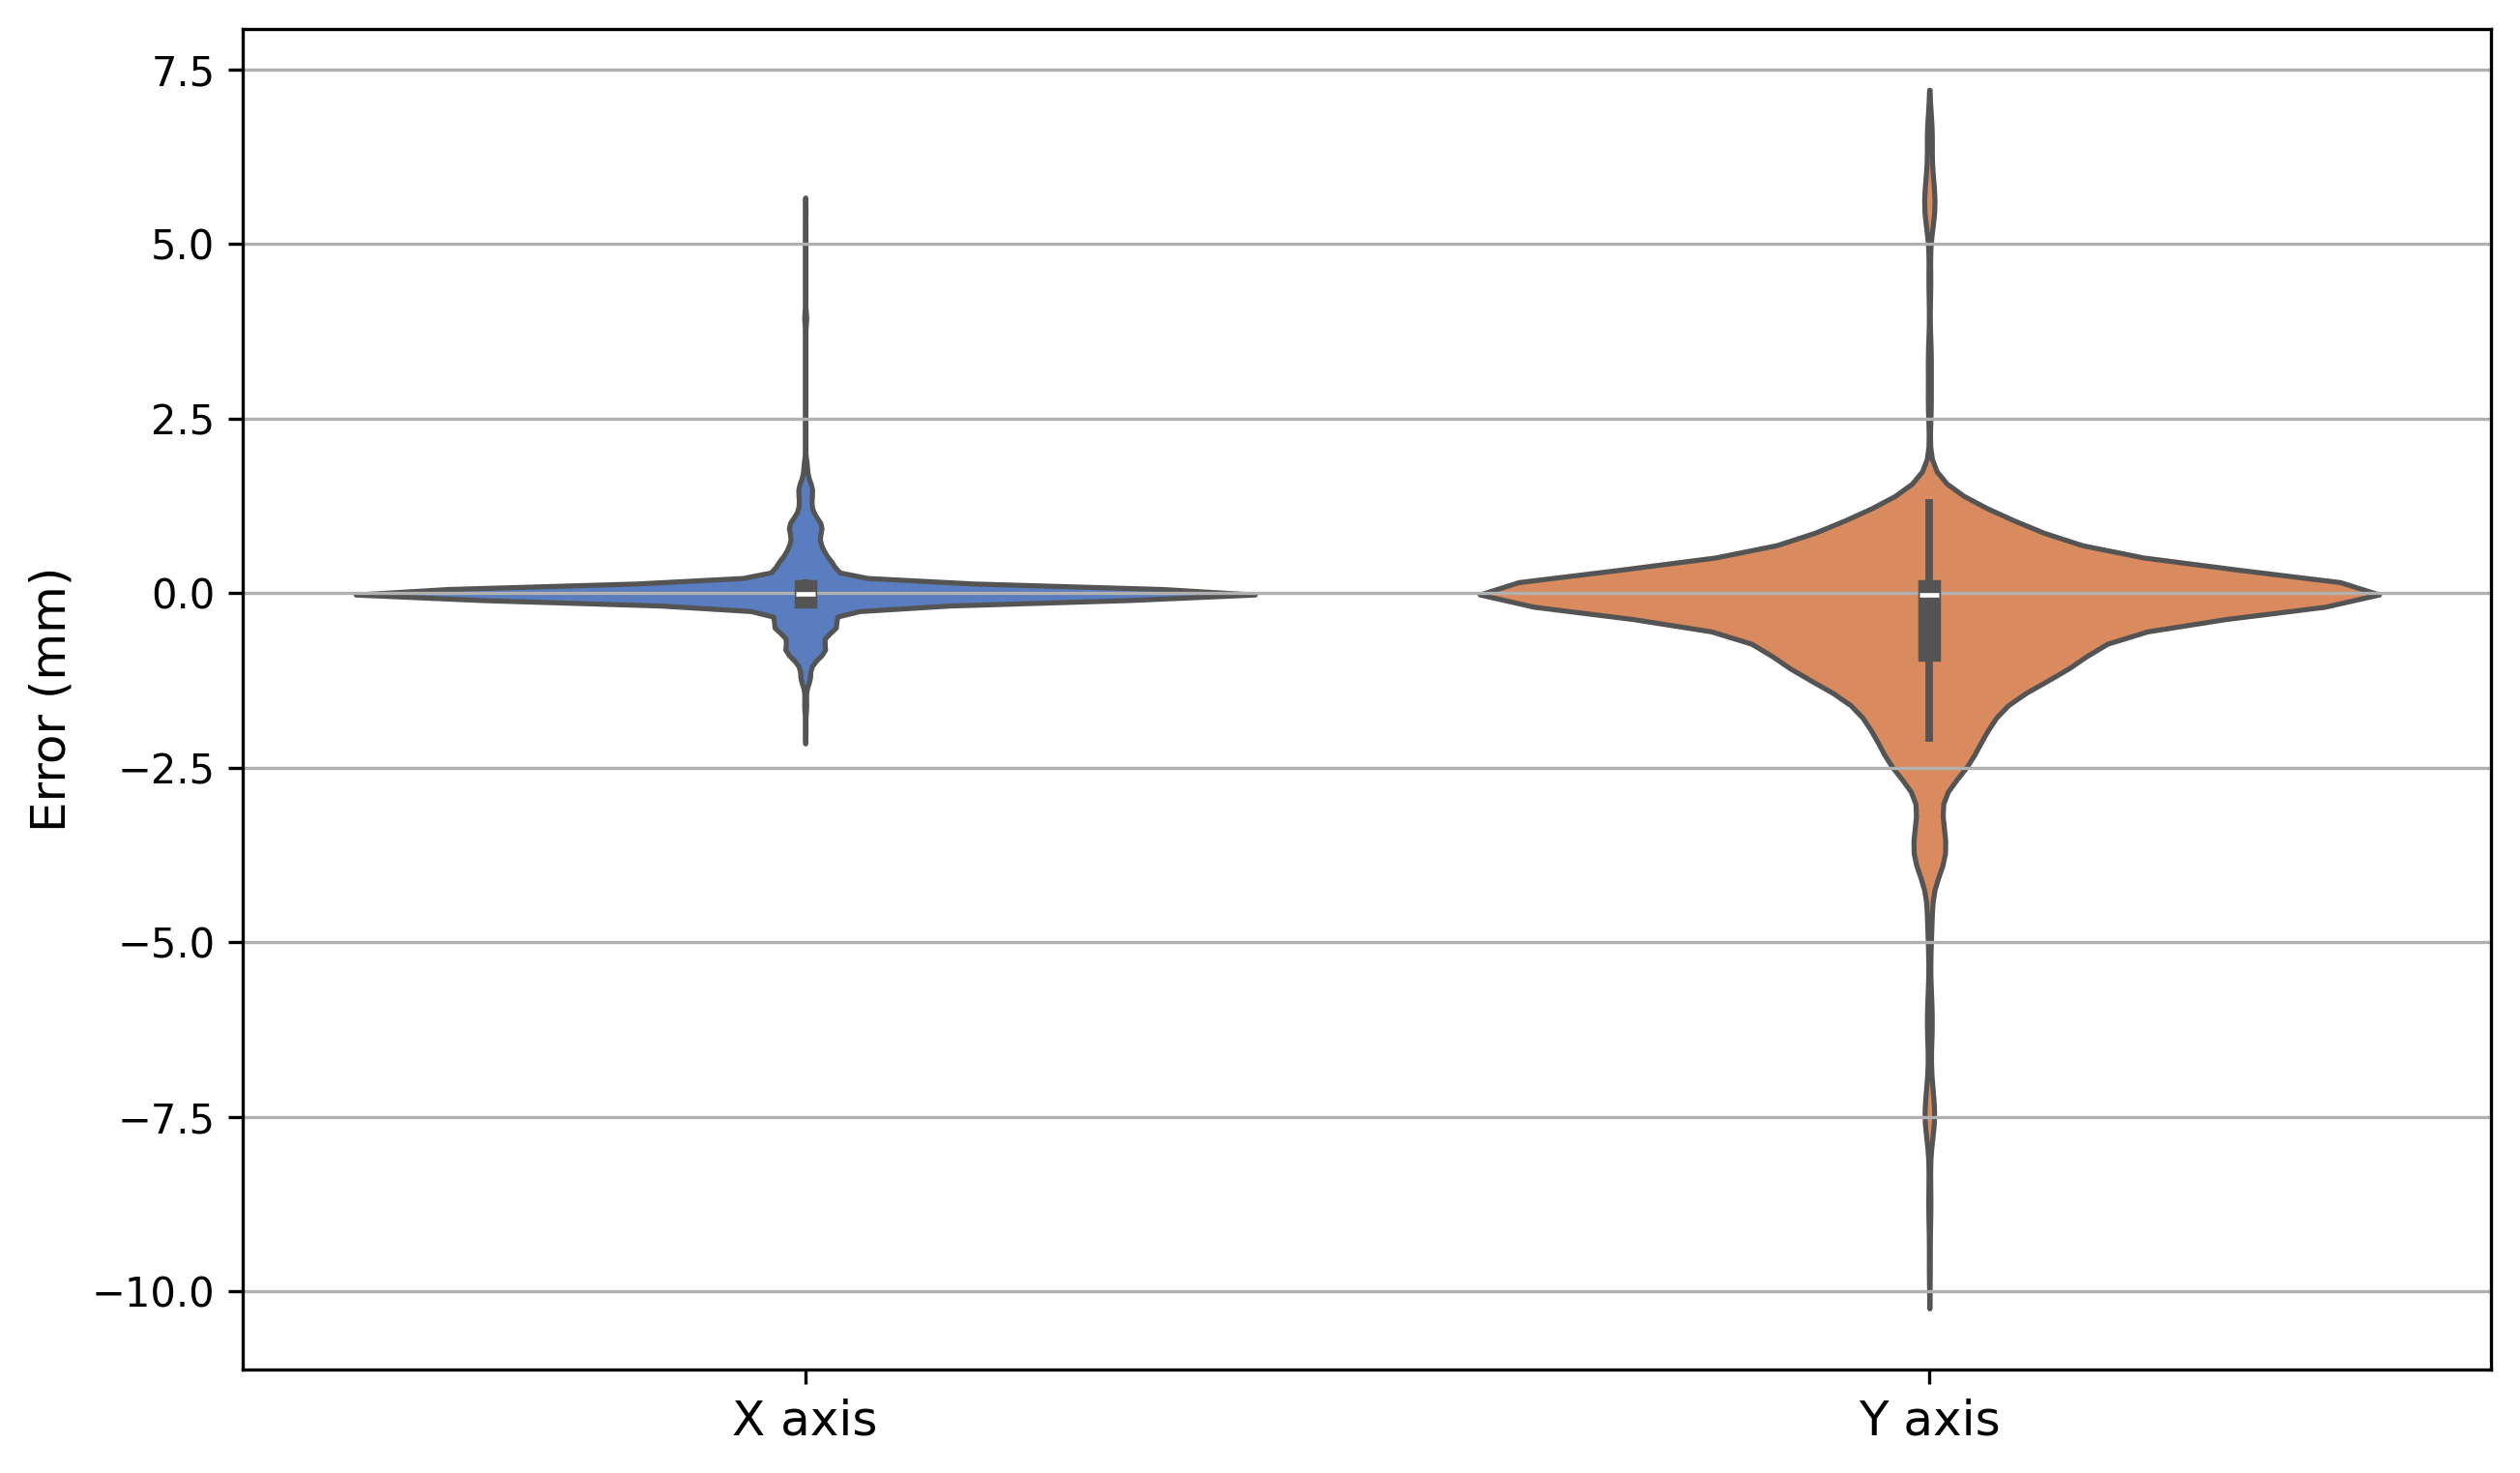

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


# 定义点到线段的距离函数,p是点，xy分别是线段的起点和终点
def point_to_segment_distance(px, py, x1, y1, x2, y2):
    # 计算线段的向量
    line_vec = np.array([x2 - x1, y2 - y1])
    point_vec = np.array([px - x1, py - y1])
    line_len_sq = np.dot(line_vec, line_vec)  # 线段长度的平方

    # 投影比例t
    if line_len_sq != 0:
        t = np.dot(point_vec, line_vec) / line_len_sq
    else:
        t = 0  # 避免除以0

    # 限制t在[0, 1]范围内
    t = max(0, min(1, t))

    # 投影点的坐标
    proj_x = x1 + t * line_vec[0]
    proj_y = y1 + t * line_vec[1]

    # 计算点到投影点的距离
    error_x = px - proj_x
    error_y = py - proj_y
    dist = np.sqrt((px - proj_x) ** 2 + (py - proj_y) ** 2)
    return dist,error_x,error_y


# 矩形的四个顶点
rectangle_x = [6.7875, 2.34313, 282.333, 287.029, 6.7875]  # X 坐标
rectangle_y = [217.443, 82.2525, 72.3898, 208.658, 217.443]  # Y 坐标


# 计算每条轨迹的误差
def calculate_errors(points_x, points_y, rect_x, rect_y,i):
    error_x_list = []
    error_y_list = []
    x1, y1 = rect_x[i], rect_y[i]
    x2, y2 = rect_x[i + 1], rect_y[i + 1]
    for px, py in zip(points_x, points_y):
        _,error_x,error_y = point_to_segment_distance(px, py, x1, y1, x2, y2)
        error_x_list.append(error_x)
        error_y_list.append(error_y)
    return error_x_list,error_y_list


# 计算所有轨迹的误差
a_error_x,a_error_y = calculate_errors(ax_points, ay_points, rectangle_x, rectangle_y,0)
b_error_x,b_error_y = calculate_errors(bx_points, by_points, rectangle_x, rectangle_y,2)
c_error_x,c_error_y = calculate_errors(cx_points, cy_points, rectangle_x, rectangle_y,3)
d_error_x,d_error_y = calculate_errors(dx_points, dy_points, rectangle_x, rectangle_y,1)

# 合并所有误差
x_error = a_error_x + b_error_x + c_error_x + d_error_x  # X 方向误差
y_error = a_error_y + b_error_y + c_error_y + d_error_y  # Y 方向误差

# 计算 RMS 值
x_rms = np.sqrt(np.mean(np.array(x_error) ** 2))
y_rms = np.sqrt(np.mean(np.array(y_error) ** 2))

print(f"RMS of X-direction error: {x_rms:.4f} mm")
print(f"RMS of Y-direction error: {y_rms:.4f} mm")

# 绘制小提琴图
plt.figure(figsize=(10, 6),dpi=300)
# sns.violinplot(data=[a_error_x, a_error_y,b_error_x, b_error_y, c_error_x, c_error_y, d_error_x, d_error_y], palette="muted", inner="box")
# plt.xticks([0, 1, 2, 3,4,5,6,7], ['a_error_x', 'a_error_y', 'b_error_x', 'b_error_y', 'c_error_x', 'c_error_y', 'd_error_x', 'd_error_y'], fontsize=12)
sns.violinplot(data=[x_error, y_error,], palette="muted", inner="box")
plt.xticks([0, 1], ['X axis', 'Y axis'], fontsize=12)
# plt.title('Error Violin Plot of Trajectory', fontsize=16)
plt.ylabel('Error (mm)', fontsize=12)
plt.grid(axis='y')
plt.show()